<a href="https://colab.research.google.com/github/Rogerio-mack/Machine-Learning-I/blob/main/ML7_SelecaoDeModelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **7. Seleção de Modelos**
---

Nesta aula você vai aprender:

*   Como selecionar melhores modelos de Classificação e Regressão
*   Sobre Outros estimadores importantes
*   Como empregar modelos de aprendizado supervisionado para a Classificação de Imagens de Dígitos e Séries Temporais

Nesta aula vamos consolidar o que você aprendeu sobre modelos de aprendizado supervisionado trabalhando dois conjuntos de dados um pouco diferentes, e que darão uma visão mais ampla do que você pode fazer com esses modelos e do que você verá na sequencia do seu curso em outras disciplinas. 

Vamos fazer aqui modelos completos de aprendizado supervisionado, tanto para Classificação (predição de classes) como para Regressão (predição de valores), selecionando não só os **melhores hiperparâmetros dos modelos**, como também a **seleção de modelos que competem** entre si. Você também terá contato com modelos importantes, como **modelos neurais** e **regressores não lineares** que, embora não venhamos a detalhar aqui os seus princípios e funcionamento, você verá que podem ser facilmente aplicados com o que você aprendeu aqui.

Ao final você terá uma receita de código completa para buscar melhores modelos tanto para problemas de classificação como de estimativa de valores.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import seaborn as sns

# Selecionando Diferentes Modelos

Vamos começar entendendo como funciona a seleção de diferentes modelos e seus parâmetros para problemas de classificação em um exemplo de brinquedo, o nosso conhecido *moons*. Mais adiante aplicaremos os mesmos princípios para um problema de classificação de imagem de dígito e para  regressores. 

Diferentes modelos criam fronteiras de decisão diferentes para os mesmos conjuntos de dados. Eles empregam critérios diferentes e, por isso, produzem classificações de modo diferente o que torna difícil você escolher empregar um modelo ou outro, muitas vezes, essa é a parte mais difícil de resolver um problema de aprendizado de máquina: *qual o estimador certo para empregar?* Não há um melhor estimador *apriori* para quaisquer dados e estimadores diferentes são mais adequados para diferentes tipos de dados e problemas. O `scikit-learn` fornece em https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html um diagrama, e que fornecemos abaixo, que funciona como um guia, embora aproximado, de como abordar problemas com relação a quais estimadores empregar. 

![imagem](https://scikit-learn.org/stable/_static/ml_map.png) 

<small>
<b> 
Figura 8. Diagrama do scikit-learn para seleção de modelos. <br></b>(Fonte: https://scikit-learn.org/)








De qualquer modo uma abordagem comum e que você encontra em sistemas de *Auto ML*, consiste em adotarmos alguma métrica, como a acuracidade ou a precisão, ou múltiplas métricas, para selecionar diferentes modelos, experimentando cada um deles, muito à exemplo do que fizemos na aula anterior para a escolha dos melhores hiperparâmetros. 




# Selecionando Classificadores

Vamos adaptar o código modelo final da aula anterior para explorar agora, não só diferentes hiperparâmetros, mas diferentes estimadores. 

Abaixo os principais classificadores do `scikit-learn` e os que empregaremos, com (\*), para seleção de um estimador para o nosso conjunto de dados *moons*:       

```
from sklearn.linear_model import LogisticRegression # (*)
from sklearn.neighbors import KNeighborsClassifier # (*)
from sklearn.tree import DecisionTreeClassifier # (*)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier # (*)
```


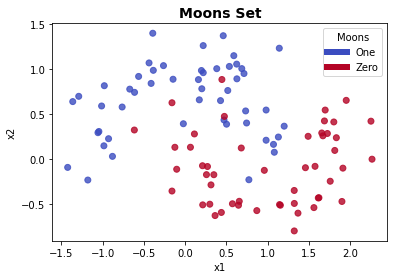

         x1        x2  y
0 -0.763251  0.577354  0
1 -0.391942  1.395641  0
2  1.324561 -0.492319  1
3  0.271295 -0.082532  1
4  2.253887  0.420281  1


In [2]:
from sklearn.datasets import make_moons
cmap_data = plt.cm.coolwarm 

X, y = make_moons(n_samples=100, noise=0.25, random_state=1234)

df = pd.DataFrame({'x1':X[:, 0], 'x2':X[:, 1], 'y':y})

plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_data, alpha=0.8)
plt.title('Moons Set',weight='bold',fontsize=14)
plt.xlabel("x1")
plt.ylabel("x2")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['One', 'Zero'], loc='upper right',title='Moons')

plt.show()

print(df.head())

In [3]:
df.to_csv('moons.csv',index=None)

In [4]:
def border(clf):
  x_min, x_max = X['x1'].min() - .5, X['x1'].max() + .5
  y_min, y_max = X['x2'].min() - .5, X['x2'].max() + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
                      np.arange(y_min, y_max, 0.2))

  if hasattr(clf, "decision_function"):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
  else:
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=cmap_data, alpha=0.8)  
  plt.scatter(X['x1'], X['x2'], c=y, cmap=cmap_data, alpha=0.8)
  plt.title(str(clf)[0:str(clf).index('(')] + ' Moons Predictions',weight='bold',fontsize=14)
  plt.xlabel("x1")
  plt.ylabel("x2")

  custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                  Line2D([0], [0], color=cmap_data(1.), lw=6)]

  plt.legend(custom_lines, ['One', 'Zero'], loc='upper right',title='Moons')

  plt.show()
  return  


Para obter os hiperparâmetros de cada modelo você pode empregar:

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
GradientBoostingClassifier().get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier()>

Abaixo um esquema geral de como avaliar os diferentes regressores com seus diferentes parâmetros e você poderá empregar outros se quiser.

LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


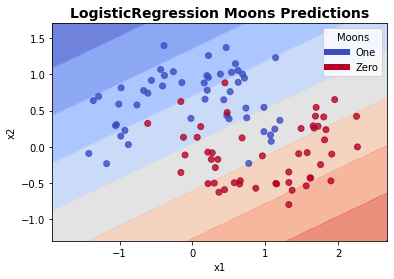


Detailed classification report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.93      0.93      0.93        15

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30


KNeighborsClassifier(metric='euclidean', n_neighbors=4)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


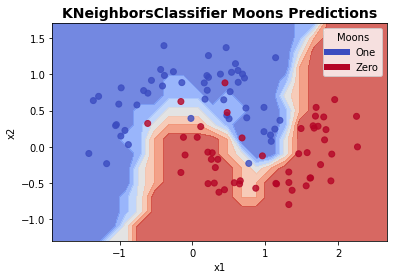


Detailed classification report:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      0.80      0.89        15

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30


DecisionTreeClassifier(max_depth=2)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


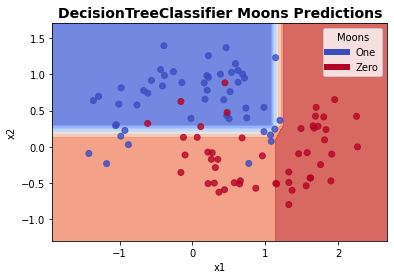


Detailed classification report:

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.82      0.93      0.87        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30


RandomForestClassifier(n_estimators=6)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


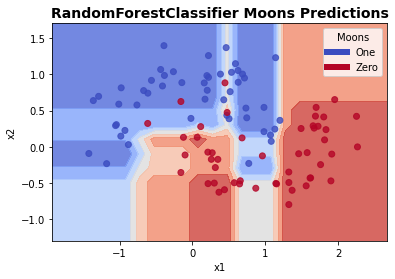


Detailed classification report:

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        15
           1       1.00      0.53      0.70        15

    accuracy                           0.77        30
   macro avg       0.84      0.77      0.75        30
weighted avg       0.84      0.77      0.75        30


GradientBoostingClassifier(n_estimators=3)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


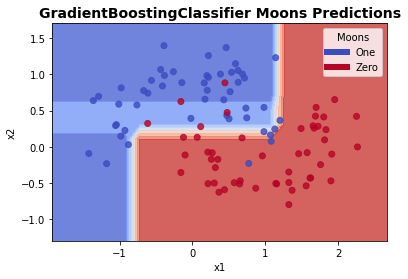


Detailed classification report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.93      0.93      0.93        15

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30




In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X = df[['x1','x2']]
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)


base_estimators = [ LogisticRegression(),
                    neighbors.KNeighborsClassifier(),
                    DecisionTreeClassifier(),
                    RandomForestClassifier(),
                    GradientBoostingClassifier()]
                    
                               
param_grids = [ {},
                {'n_neighbors': [3,4,5], 'metric': ['euclidean','manhattan']},
                {'max_depth': [2,3,4,5]},
                {'n_estimators':[3,4,5,6]}, 
                {'n_estimators':[3,4,5,6]}]             
                
for i in range(len(base_estimators)):
  clf = GridSearchCV(base_estimators[i], param_grids[i], cv=5, scoring='accuracy')
  clf.fit(X_train, y_train)
  # print(clf.cv_results_)
  print(clf.best_estimator_)
  border(clf.best_estimator_)
  print()
  print("Detailed classification report:")
  print()
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  print()


Analisando os dados os melhores resultados são os resultados dos modelos Gradiente Boosting e Regressão Logística e, neste caso, deveríamos empregar o modelo mais simples de Regressão Logística seguindo o princípio da parcimônia. Este entretanto é um exemplo de brinquedo, mas serve para mostrar que nem sempre modelos mais elaborados irão fornecer a melhor predição dos dados.

# CASO: Classificando Imagens de Dígitos ($8 \times 8$)

Agora você pode aplicar as técnicas seleção de classificadores que aprendeu acima para um problema mais interessante. Vamos empregar isso para a classificação de iamgens de dígitos escritos à mão, algo que é uma importante parte do problema de reconhecimento óptico de caracteres. Um conjunto de dígitos exemplo já pré-formatados pode ser encontrado como parte da bibliteca Scikit-Learn, contendo 797 amostras de dígitos em uma matriz de 8 × 8 pixels (um vetor de 64 posições). 



## Entendendo os Dados

In [7]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [8]:
digits['data'].shape

(1797, 64)

Podemos ver as imagens, por exemplo, dos dígitos 1, 2 e 3 que fazem parte desses exemplos.

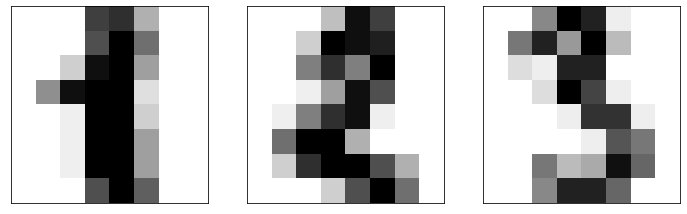

In [9]:
fig = plt.figure(figsize=(12, 4))

for i in range(1,4):
  plt.subplot(1,3,i)
  plt.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
  plt.xticks([])
  plt.yticks([])
plt.show()

E cada imagem traz ainda o *rótulo* de classificação do dígito escrito à mão:

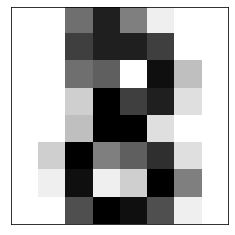

Este dígito é um:  8


In [10]:
i = 8 # entre com um valor entre 0 e 796
fig = plt.figure(figsize=(4, 4))

plt.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.show()

print('Este dígito é um: ', digits.target[i])

Resumindo, temos aqui um conjunto de treinamento com 797 exemplos de dígitos à mão rotulados. Os atributos de entrada,`X` do nosso conjunto, são os valores de pixels da imagem 8x8 `digits.imagens`. Por comodidade vamos empregar os valores reformatados para um vetor 64x1 `digits.data`, o que também poderia ser obtido com um `reshape()` do Numpy sobre a imagem. Os rótulos de cada imagem, nossa variável objetivo `y`, encontra-se em `digits.target`.

In [11]:
digits.images[i]

array([[ 0.,  0.,  9., 14.,  8.,  1.,  0.,  0.],
       [ 0.,  0., 12., 14., 14., 12.,  0.,  0.],
       [ 0.,  0.,  9., 10.,  0., 15.,  4.,  0.],
       [ 0.,  0.,  3., 16., 12., 14.,  2.,  0.],
       [ 0.,  0.,  4., 16., 16.,  2.,  0.,  0.],
       [ 0.,  3., 16.,  8., 10., 13.,  2.,  0.],
       [ 0.,  1., 15.,  1.,  3., 16.,  8.,  0.],
       [ 0.,  0., 11., 16., 15., 11.,  1.,  0.]])

In [12]:
digits.images[i].reshape(64)

array([ 0.,  0.,  9., 14.,  8.,  1.,  0.,  0.,  0.,  0., 12., 14., 14.,
       12.,  0.,  0.,  0.,  0.,  9., 10.,  0., 15.,  4.,  0.,  0.,  0.,
        3., 16., 12., 14.,  2.,  0.,  0.,  0.,  4., 16., 16.,  2.,  0.,
        0.,  0.,  3., 16.,  8., 10., 13.,  2.,  0.,  0.,  1., 15.,  1.,
        3., 16.,  8.,  0.,  0.,  0., 11., 16., 15., 11.,  1.,  0.])

In [13]:
digits.data[i]

array([ 0.,  0.,  9., 14.,  8.,  1.,  0.,  0.,  0.,  0., 12., 14., 14.,
       12.,  0.,  0.,  0.,  0.,  9., 10.,  0., 15.,  4.,  0.,  0.,  0.,
        3., 16., 12., 14.,  2.,  0.,  0.,  0.,  4., 16., 16.,  2.,  0.,
        0.,  0.,  3., 16.,  8., 10., 13.,  2.,  0.,  0.,  1., 15.,  1.,
        3., 16.,  8.,  0.,  0.,  0., 11., 16., 15., 11.,  1.,  0.])

In [14]:
digits.target[i]

8

Observe aqui outros exemplos dos dados.

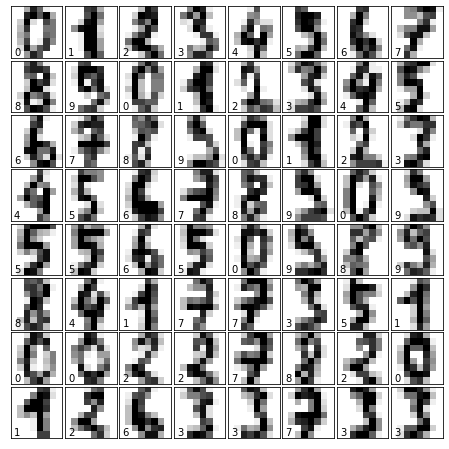

In [15]:
#@markdown you can skip this code
# source: https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Nosso problema agora é contruir um melhor modelo de classificação de dígitos escritos à mão com o nosso conjunto de treinamento.

## Aplicando os Classificadores

Vamos inicialmente aplicar somente os classificadores que já conhecemos como o classificador logístico, o Knn, a Árvore de Decisão e a Floresta Aleatória. 

Vamos variar esses modelos criando uma lista desses estimadores e implementando um laço de treinamento sobre essa lista, assim como fizemos na aula 5. Dentro de laço de treinamento implementamos uma busca em grade dos melhores hiperparâmetros de cada modelo da nossa lista. Acumulando as métricas de cada resultado, como a acuracidade por exemplo, você poderá escolher o melhor modelo com os melhores hiperparâmetros para essa métrica. 

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

base_estimators = [ LogisticRegression(max_iter=10000),
                    KNeighborsClassifier(),
                    DecisionTreeClassifier(),
                    RandomForestClassifier(random_state=0) ]
                                                   
param_grids = [ {},
                {'n_neighbors': [3,4,5,6,7]},
                {'max_depth': [2,3,4,5,6,7,8,9,10], 'criterion': ['gini','entropy']},
                {'n_estimators':[3,4,5,6],'max_depth': [2,3,4,5,6,7,8,9,10], 'criterion': ['gini','entropy']}]             
                
save_estimators = []

for i in range(len(base_estimators)):
  clf = GridSearchCV(base_estimators[i], param_grids[i], cv=5, scoring='accuracy')
  clf.fit(X_train, y_train)
  # print(clf.cv_results_)
  print(clf.best_estimator_)
  save_estimators.append(clf.best_estimator_)
  print()
  print("Detailed classification report:")
  print()
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred))
  print()




LogisticRegression(max_iter=10000)

Detailed classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.90      0.98      0.94        55
           2       1.00      0.98      0.99        53
           3       0.95      0.96      0.95        55
           4       1.00      0.96      0.98        54
           5       0.95      0.96      0.95        55
           6       1.00      0.98      0.99        54
           7       0.98      0.98      0.98        54
           8       0.96      0.90      0.93        52
           9       0.94      0.94      0.94        54

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540


KNeighborsClassifier()

Detailed classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
     

Com os parâmetros acima o melhor estimador obtido foi o Knn com um score de 0.979. Bem difícil de ser melhorado... rs.

In [17]:
[x.score(X_test, y_test) for x in save_estimators]

[0.9666666666666667,
 0.9796296296296296,
 0.8611111111111112,
 0.9148148148148149]

In [18]:
best = np.array( [x.score(X_test, y_test) for x in save_estimators] ).argmax()
save_estimators[best]

KNeighborsClassifier()

O estimador está usando os parâmetros padrão, como por exemplo a quantidade de vizinhos mais próximos 5 e a métrica de distância *minkowski*.

```
n_neighbors=5, metric='minkowski'
``` 

Mas você pode ainda aplicar esse mesmo procedimento para outros modelos que você venha a ter interesse, embora não entraremos em detalhe aqui. Por exemplo, abaixo, vamos aplicar os classificadores de Gradient Boosting, Support Vector Machines (SVC) e uma rede neural multicamadas (MLP), poderosos classificadores empregados para muitos problemas complexos principalmente envolvendo dados com grande dimensionalidade como imagens e vídeos. 

In [19]:
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier  
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier 

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

base_estimators = [ MLPClassifier(max_iter=5000),
                    GradientBoostingClassifier(),
                    SVC() ]
                                                   
param_grids = [ {'hidden_layer_sizes':[(20,),(50,),(100,),(50,50)], 'activation': ['relu','tanh']},
                {},
                {}]             
                
save_estimators = []

for i in range(len(base_estimators)):
  clf = GridSearchCV(base_estimators[i], param_grids[i], cv=5, scoring='accuracy')
  clf.fit(X_train, y_train)
  # print(clf.cv_results_)
  print(clf.best_estimator_)
  save_estimators.append(clf.best_estimator_)
  print()
  print("Accuracy score:")
  print()
  y_pred = clf.predict(X_test)
  print(clf.score(X_test, y_test))
  print()


MLPClassifier(activation='tanh', max_iter=5000)

Accuracy score:

0.9814814814814815

GradientBoostingClassifier()

Accuracy score:

0.9629629629629629

SVC()

Accuracy score:

0.987037037037037



Acima empregamos uma rede neural variando o número de camadas da rede e a função de ativação empregadas. Todos tiveram um desempenho próximo ou superior ao Knn anterior. De fato esses modelos são bastante poderosos e populares, mas cuidado, o resultado melhor aqui não é uma regra! Isso nem sempre se verifica e você já aprendeu aqui que o melhor modelo depende mesmo sempre dos dados!  Não é surpresa, entretanto, o melhor desempenho do modelo de Máquinas de Vetores de Suporte (SVC()) que se popularizou exatamente pelo seu desempenho superior na classificação de dígitos nos anos 90. 

# CASO: Classificando o MNIST ($28 \times 28$)

Um conjunto mais interessantes de dígitos escritos à mão é o famoso **MNIST** (http://yann.lecun.com/exdb/mnist/) sendo um conjunto de dados *benchmark* para algoritmos de  classificação bastante empregado.

Ele é constituído por 70000 imagens de dígitos rotulados escritos à mão em imagens de 28x28 pixels. Um conjunto bastante mais complexo que o anterior. Vamos aplicar aqui apenas os modelos que encontramos os melhores resultados antes, como o K-vizinhos mais próximos, o modelo neural e o de vetores de suporte. A exploração dos dados e a aplicação dos modelos do código anterior é bastante direta e dispensa comentários para código. A execução, entretanto, pode levar aqui alguns minutos.




In [20]:
%%time
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

CPU times: user 46.3 s, sys: 2.9 s, total: 49.2 s
Wall time: 1min 4s


In [21]:
mnist.data.shape

(70000, 784)

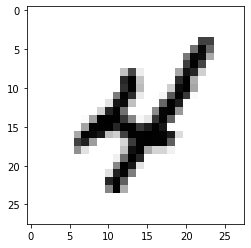

Este dígito é um:  4


In [22]:
i = 9 # entre com um valor entre 0 e 796
fig = plt.figure(figsize=(4, 4))

image = mnist.data.to_numpy()
plt.imshow((image[i].reshape(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

print('Este dígito é um: ', mnist.target[i])

In [23]:
mnist.data.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
mnist.target.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [25]:
%%time
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

X = mnist.data[0:100] # retire os [] se tiver certeza de querer executar com os 70K dados. Deve levar mais de 30min de execução.
y = mnist.target[0:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

base_estimators = [ MLPClassifier(max_iter=5000),
                    KNeighborsClassifier(),
                    SVC() ]
                                                   
param_grids = [ {'hidden_layer_sizes':[(100,),(32,32),(32,64,32)], 'activation': ['relu','tanh']},
                {'n_neighbors':[3,4,5,6,7,8,9,10]},
                {}]             
                
save_estimators = []

for i in range(len(base_estimators)):
  clf = GridSearchCV(base_estimators[i], param_grids[i], cv=5, scoring='accuracy')
  clf.fit(X_train, y_train)
  # print(clf.cv_results_)
  print(clf.best_estimator_)
  save_estimators.append(clf.best_estimator_)
  print()
  print("Accuracy score:")
  print()
  y_pred = clf.predict(X_test)
  print(clf.score(X_test, y_test))
  print()


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


MLPClassifier(max_iter=5000)

Accuracy score:

0.7666666666666667



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


KNeighborsClassifier(n_neighbors=3)

Accuracy score:

0.6

SVC()

Accuracy score:

0.7333333333333333

CPU times: user 25.1 s, sys: 16.7 s, total: 41.8 s
Wall time: 22.4 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


# Selecionando Regressores

A mesma abordagem empregada para selecionar modelos e hiperparâmetros de classificadores pode ser empregada para a seleção de regressores. A regressão linear foi um dos primeiros modelos supervisionados que aprendemos aqui. Você deve lembrar: a regressão linear busca fazer a aproximação de uma função desconhecida:

$$f:(x_1, x_2, \dots, x_n) \rightarrow y$$

Mas para a qual temos um conjunto de dados de treinamento (exemplos de entradas e as respectivas saídas da função), para uma função linear da forma:

$$\hat f:(x_1, x_2, \dots, x_n) \rightarrow  \hat y = a_0 + a_1 x_1 + a_2 x_2 + \dots + a_n x_n$$

Onde $a_i$, são os coeficientes que minimizam o erro,

$$ \min_{a_i} Erro( y, \hat y)$$

Isso resolve uma série de problemas bastante interessantes como a predição de preço de imóveis ou de veículos. Mas há uma série de problemas, até mesmo simples, onde um regressor linear não é suficientemente adequado. Existem assim inúmeros outros regressores que podem ser aplicados do mesmo modo que a regressão linear para obter uma estimativa **não linear** dos dados. 

$$\hat f:(x_1, x_2, \dots, x_n) \rightarrow  \hat y = g(x_1, x_2, \dots, x_n)$$

Onde $g()$ agora é uma função não linear que queremos que o erro da função estimada seja mínimo por alguma métrica (isto é a diferença entre $y$ e $\hat y$).

$$ \min_{g} Erro( y, \hat y)$$

 

# CASO: Um Conjunto não Linear, Potencial de Ação de um Neurônio

Vamos empregar como exemplo um subconjunto de dados do Potencial de Ação de um neurônio. O Potencial de Ação é uma *função* que explica a ativação dos neurônios e que tem um papel importante nas neurociências e aplicações médicas. Essa é uma função claramente não linear como você pode observar pelo gráfico onde o `sns.lineplot` produz uma linha de tendência para os dados e seu intervalo de confiança. Não obstante haverem uma série de modelos propostos, nós não conhecemos a *função real* desse potencial, mas podemos obter uma série de medidas no tempo (como o subconjunto empregado aqui) e buscar aproximar esses dados por algum modelo ou função. 



In [68]:
import seaborn as sns
df = sns.load_dataset('dots')
df = df[(df.choice == 'T2') & (df['align'] == 'dots')]
df = df[['time','firing_rate']].reset_index(drop=True)
df.head()

,time,firing_rate
0,-80,34.970107
1,-80,36.785815
2,-80,34.478506
3,-80,34.991424
4,-80,32.241533


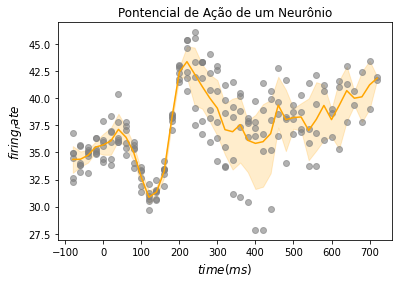

In [69]:
sns.lineplot(x=df.time, y=df.firing_rate,color='orange')
plt.scatter(x=df.time, y=df.firing_rate,color='gray',alpha=0.6)

plt.title('Pontencial de Ação de um Neurônio')
plt.xlabel('$time (ms)$',fontsize=12)
plt.ylabel('$firing_rate$',fontsize=12)
plt.show()

## Aplicando o Modelo Linear

Podemos aplicar diretamente o modelo de regressão linear como já fizemos antes e comparar nossas estimativas com os dados. Aplicamos aqui uma separação de dados de treinamento e teste para tornar a avaliação do modelo mais efetiva. 

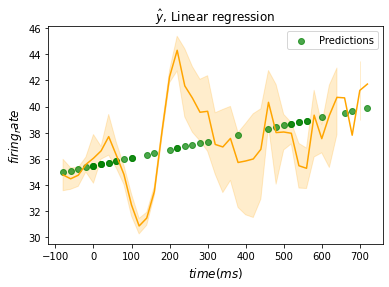

In [70]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X = df[['time']]
y = df.firing_rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

sns.lineplot(x=X_train.time,y=y_train,color='orange')
plt.scatter(X_test,y_pred,color='green',marker='o',alpha=0.7,label='Predictions')

plt.title('$\\hat{y}$' + ', Linear regression')
plt.xlabel('$time (ms)$',fontsize=12)
plt.ylabel('$firing_rate$',fontsize=12)
plt.legend()

plt.show()

Esse é o melhor modelo que a classe de regressores lineares pode fornecer e, de fato, você observa que ele se ajusta muito pouco aos dados. Modelos lineares não podem capturar a não linearidade da função de ativação! 



## Regressores não Lineares

Existem muitos outros modelos e que empregam paradigmas bastante diferentes do modelo Linear e permitem obter aproximações *não lineares* dos dados. Você pode por exemplo pensar que podemos aproximar uma função por diferentes polinômios, com diferentes graus, ou ainda por diferentes combinações de séries de dados como as séries de Taylor e Fourier, famosas séries aproximadoras de funções na matemática.

Para nós é suficiente saber que existem muitos modelos e que, por partirem de princípios de construção diferentes, levam a diferentes soluções de aproximação da função original.

Você pode ver abaixo a aplicação de 3 modelos regressores bastante empregados o **Decision Tree Regressor**, um modelo baseado em **Máquinas de Vetores de Suporte** e **XGBoosting Regressor**. Todos tem a mesma lógica de aplicação dos estimadores do scikit-learn e da regressão linear. Você pode ainda alterar o código abaixo para experimentar outros modelos que encontram-se nos imports no início do código.

[14:21:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


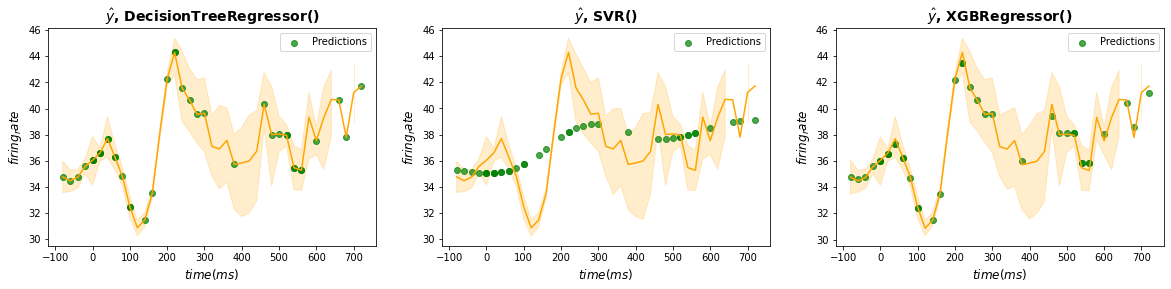

In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor # entradas precisam ser normalizadas

base_estimators = [ DecisionTreeRegressor(),
                    SVR(),
                    XGBRegressor() ]

plt.figure(figsize=(20,4))
k = 1
for regressor in base_estimators:

  regressor.fit(X_train, y_train)

  y_pred = regressor.predict(X_test)

  plt.subplot(1,3,k)
  k = k + 1
  sns.lineplot(x=X_train.time,y=y_train,color='orange')
  plt.scatter(X_test,y_pred,color='green',marker='o',alpha=0.7,label='Predictions')

  plt.title('$\\hat{y}$, ' + str(regressor),fontsize=14,weight='bold')
  plt.xlabel('$time (ms)$',fontsize=12)
  plt.ylabel('$firing_rate$',fontsize=12)
  plt.legend()

plt.show()



Neste exemplo omitimos por simplicidade a busca dos melhores modelos ou mesmo a a busca em grade por melhores hiperparâmetros, limitando-nos simplesmente a construir os diferentes modelos. 

Mas você já pode perceber que podemos aplicar o mesmo raciocínio empregado antes para os classificadores, definindo uma métrica de regressão para os melhores modelos e selecionando assim modelos e hiperparâmetros que mais se ajustam aos dados. É o que faremos a seguir.

In [72]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor # entradas precisam ser normalizadas

X = df[['time']]
y = df.firing_rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

base_estimators = [ MLPRegressor(max_iter=8000),
                    DecisionTreeRegressor(),
                    SVR(),
                    XGBRegressor() ]
                                              
param_grids = [ {'hidden_layer_sizes':[(32,),(8,8),(8,16,8)], 'activation': ['logistic','tanh'], 'solver':['sgd', 'adam']},
                {'max_depth':[3,4,5]},
                {},
                {}]             
                
save_estimators = []

for i in range(len(base_estimators)):
  reg = GridSearchCV(base_estimators[i], param_grids[i], cv=5, scoring='neg_mean_squared_error')
  reg.fit(X_train, y_train)
  # print(clf.cv_results_)
  print(reg.best_estimator_)
  save_estimators.append(reg.best_estimator_)
  print()
  print("MSE Mean Square Error:")
  print()
  y_pred = reg.predict(X_test)
  print(reg.score(X_test, y_test))
  print()


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (8000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(activation='logistic', hidden_layer_sizes=(32,), max_iter=8000)

MSE Mean Square Error:

-9.001852217669798

DecisionTreeRegressor(max_depth=4)

MSE Mean Square Error:

-3.432988535863749

SVR()

MSE Mean Square Error:

-7.82387506810357

[14:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

In [73]:
save_estimators

[MLPRegressor(activation='logistic', hidden_layer_sizes=(32,), max_iter=8000),
 DecisionTreeRegressor(max_depth=4),
 SVR(),
 XGBRegressor()]

Empregamos agora 4 diferentes regressores e diferentes hiperparâmetros. A escolha recai sobre a melhor métrica de **MSE (Mean Square Error)**, uma métrica comum para regressores onde medimos o erro médio com relação a predição e os dados do conjunto de teste. Diferentemente da acuracidade (uma métrica para classificação) aqui o melhor modelo é o que apresenta o menor erro médio. Nos estimadores acima nossa escolha recairia sobre o modelo `DecisionTreeRegressor(max_depth=4)`.




# CASO: Bike Sharing Prediction

Vamos explorar aqui uma caso mais interessante. Vamos aplicar os regressores para a predição de uma Série Temporal! Não vamos entrar em detalhes aqui sobre o que caracteriza uma Série Temporal e você deve estudar melhor isso em outras disciplinas ao longo do curso. Você também deve estudar muitos outros modelos estatísticos que permitem análise e previsão de Séries Temporais, modelos como AR (autoregressivos), MA (médias móveis), ARIMA (autoregressivo integrado com médias móveis) etc. Nossa abordagem aqui é portanto bastante simples e apenas visa mostrar para você a possibilidade de empregarmos o aprendizado de máquina para esse tipo de problema.

Para nós basta entendermos que Séries Temporais são um conjuto de valores que variam no tempo: o preço de uma ação na bolsa de valores, com diferentes valores de fechamento para cada dia do ano; o preço mensal do petróleo ao longo dos últimos 10 anos; a série de valores de temperatura média da terra, ou de emissões de CO2 ao longo dos últimos 30 anos; o volume de vendas diário da Amazon nos últimos 3 anos; são todos dados de Séries Temporais, que variam ao longo do tempo apresentando ciclos, tendências e sazonalidades. É também bastante claro a importância de fazermos previsões para esses valores (o valor de uma ação para os próximos 30 dias; a emissão de CO2 para os próximos 5 anos; ou ainda a previsão de vendas da Amazon para o mês de Dezembro). Assim, esse é um problema que pode nos interessar aplicar as técnicas de aprendizado supervisionado para fazer previsões, não obstante muitos outros métodos estatísticos disponíveis para isso. 

O conjunto de dados Bike Sharing é uma Série bastante complexa mas com características bastante comuns a um grande número de problemas que envolvem demanda de produtos e serviços e vamos buscar fazer previsões do aluguel de bicicletas empregando regressores.  

## Preparação dos Dados

Nosso arquivo traz dados hora a hora da demanda do aluguel de bicicletas e, após a indexação dos dados, vamos fazer um *resample* para transformar os dados horários em valores máximos por dia. A ideia é a predição dos valores máximos para que não haja falta da oferta do serviço.

> *O Pacote Pandas traz várias facilidades de manipulação de dados de Séries Temporais quando empregamos índices do DataFrame com a dimensão de tempo (data, hora etc.). São operações que seriam difíceis de serem implementadas 'by scratch', como fazer o `resample` ou o `shift` dos dados.*

In [74]:
df = pd.read_csv('https://github.com/Rogerio-mack/Temporal/raw/main/Data/london_merged.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


Embora existam muitos outros dados aqui, como os dados climático, e que poderiam ser também empregados para melhor o poder preditivo dos modelos vamos nessa introdução empregar apenas os valores de quantidade de bicicletas alugadas (`cnt`). Modelos que empregam uma única Série de dados para previsão são modelos univariados, enquanto modelos multivariados empregam múltiplas Séries. Mas não vamos chegar a estudar esses modeloas aqui. 

In [75]:
from datetime import datetime

df.timestamp = pd.to_datetime(df.timestamp)
df['year'] = df.timestamp.dt.year
df = df[df.year == 2015]
df = df.set_index('timestamp')

In [76]:
df_resample = df.copy()
df_resample = df_resample.resample('D').max()

In [77]:
df_resample = df_resample[['cnt']]
df_resample.head()

,cnt
timestamp,
2015-01-04,1039
2015-01-05,3161
2015-01-06,3534
2015-01-07,3618
2015-01-08,2351


A série de dados que temos interesse é agora a dos valores `cnt`, valores máximos de demanda de bicicletas por dia e representada pela linha amarela no gráfico abaixo. 

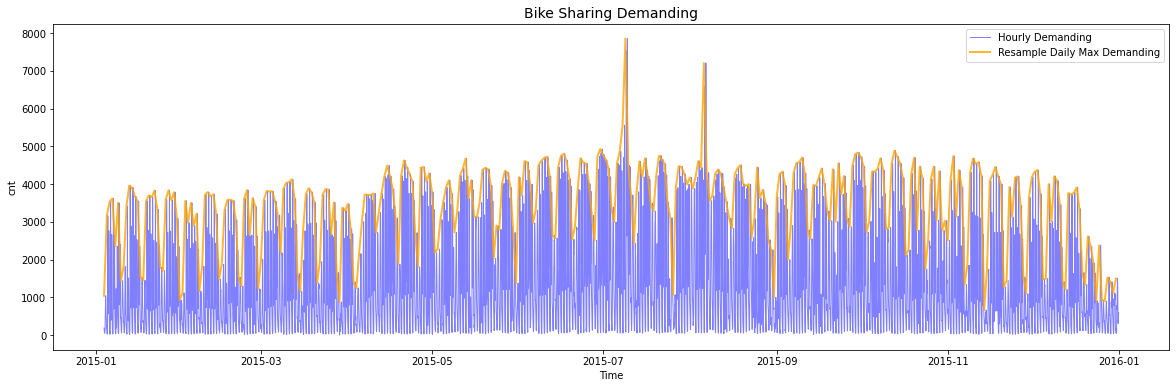

In [78]:
plt.figure(figsize=(20,6))

sns.lineplot(x = df.cnt.index, y = df.cnt, color='blue', alpha=0.5, label='Hourly Demanding',lw=1)
sns.lineplot(x = df_resample.cnt.index, y = df_resample.cnt, color='orange', alpha=0.8, label='Resample Daily Max Demanding',lw=2)

plt.title('Bike Sharing Demanding',fontsize=14)
plt.xlabel('Days Hours')
plt.xlabel('Time')
plt.show()

## Estabelecendo o Problema

Nosso problema agora é fazer uma previsão no número de aluguéis de bicicletas diário (atributo `cnt`) criando um modelo que aproxima os valores históricos que temos no nosso conjunto de dados. Aqui também é útil separarmos nesse conjunto de treinamento uma porção dos dados para teste e, assim, podermos minimizar os efeitos de sobreajuste do modelo e sua perda de previsibilidade para novos dados. A representação da Série que desejamos aproximar encontra-se representada no gráfico a seguir.



In [79]:
df = df_resample
df.head()

,cnt
timestamp,
2015-01-04,1039
2015-01-05,3161
2015-01-06,3534
2015-01-07,3618
2015-01-08,2351


In [80]:
test_size = int(0.2*len(df))
train_size = len(df) - test_size

# Create Training and Test
train = df.cnt[:train_size]
test = df.cnt[train_size:]

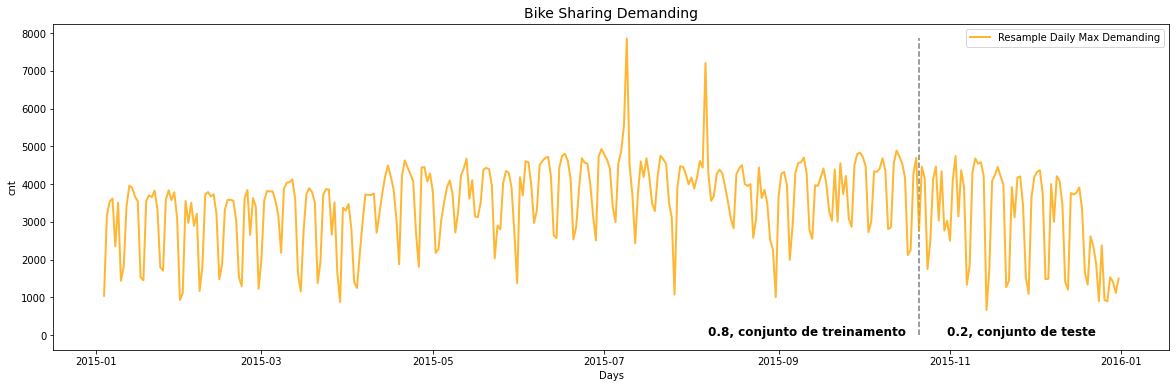

In [81]:
plt.figure(figsize=(20,6))

sns.lineplot(x = df.cnt.index, y = df.cnt, color='orange', alpha=0.8, label='Resample Daily Max Demanding',lw=2)

plt.title('Bike Sharing Demanding',fontsize=14)
plt.xlabel('Days Hours')
plt.xlabel('Days')

plt.vlines(x=df.cnt.index[train_size]  , ymin=0, ymax=df.cnt.max(), color='gray', linestyle='--')

plt.text(df.cnt.index[train_size - 75] , 0 , '0.8, conjunto de treinamento', fontsize=12, weight='bold')
plt.text(df.cnt.index[train_size + 10]  , 0 , '0.2, conjunto de teste', fontsize=12, weight='bold')
plt.legend()

plt.show()

O conjunto de treinamento e teste aqui, entretanto, é construído de forma um pouco diferente que nas tarefas de classificação. No lugar de fazermos uma seleção aleatória, como queremos prever dados futuros com base em dados passados, escolhemos um intervalo contínuo de datas passadas para treinamento e o todo o intervalo restante (datas futuras) como teste. Existem uma série de outros procedimentos de validação e testes que poderíamos aplicar aqui mas, para essa introdução, vamos nos limitar a aplicar esse modelo simples.

In [82]:
#@markdown
def plot_forecast(y, y_pred, X_train, title='Forecasting'):

  plt.figure(figsize=(20,6))
  plt.plot(y, color='orange', alpha=0.95, label='Real')
  plt.plot(y_pred, color='darkred', alpha=0.6, label='Forecast', marker='o')
  plt.plot(y_pred[0:X_train.shape[0]], color='blue', alpha=0.6, label='Predicted', marker='o')

  plt.vlines(x=y.index[X_train.shape[0]] , ymin=0, ymax=y.max(), color='gray', linestyle='--')

  plt.title(title, fontsize=14, weight='bold')
  plt.xlabel('Days Hours')
  plt.xlabel('Bike Demands')

  plt.text(y.index[X_train.shape[0] - 75] , 0 , '0.8, conjunto de treinamento', fontsize=12, weight='bold')
  plt.text(y.index[X_train.shape[0] + 10] , 0 , '0.2, conjunto de teste', fontsize=12, weight='bold')
  plt.legend()
  plt.show()

  return



In [83]:
#@markdown
# metrics
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual, print_flag=True):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                           # ME
    mae = np.mean(np.abs(forecast - actual))                  # MAE
    mpe = np.mean((forecast - actual)/actual)                 # MPE
    mse = np.mean((forecast - actual)**2)                     # MSE
    rmse = np.mean((forecast - actual)**2)**.5                # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                 # CORR
    acf1 = acf(forecast - actual)[1]                          # ACF1

    metrics = {'MSE':mse, 'MAPE':mape, 'ME':me, 'MAE': mae, 'MPE': mpe, 'RMSE':rmse, 'ACF1':acf1, 'CORR':corr}

    if print_flag:
      for key, value in metrics.items():
        print(f'{key}: \t {value:.2f}')
    
    return metrics



## Feature Engineering

Nossos dados agora têm o seguite aspecto:

In [84]:
df.head()

,cnt
timestamp,
2015-01-04,1039
2015-01-05,3161
2015-01-06,3534
2015-01-07,3618
2015-01-08,2351


**Como transformar isso em um problema de aproximação de mapeamento de entradas e saídas?** Isto é, como transformar isso em um problema que aproxima uma função,

$$ f(X) \rightarrow y $$

dado um conjunto de dados $m \times n$, em que $m$ é o número de instâncias com $n$ atributos?

$$ x_1^{(1)}, x_2^{(1)}, \dots , x_n^{(1)} \rightarrow y^{(1)} $$
$$ x_1^2, x_2^{(2)}, \dots , x_n^{(2)} \rightarrow y^{(2)} $$
$$ \dots  $$
$$ x_1^{(m)}, x_2^{(m)}, \dots , x_n^{(m)} \rightarrow y^{(m)} $$

**Olhando nosso conjunto de dados `df` tem uma única variável!  Se esses são os valores de $y$ onde estão os valores de $x$???**


Aqui é que entra a ideia de engenharia de atributos, ou *feature engineering*: **você vai criar o valor desses atributos**. 

Uma ideia comum às Séries Temporais é a de que os valores presentes dependem dos valores passados da Série. Por exemplo, o valor do BitCoin hoje depende mais dos valores de ontem e de anteontem do que dos valores da semana passada, mas mais dos valores da semana passada do que dos valores de um ano atrás. O número de passagens aéreas apresenta *sazonalidades*, períodos diferentes do tempo como finais de semana e o final do ano influenciam fortemente no número de viagens e, assim, o número de passagens aéreas vendidas no final de semana ou no final do ano pode apresentar forte relação com os mesmos valores no final de semana passado no ou final do ano anterior. Você vai aproveitar essa ideia para construir as variáveis do seu modelo.

A ideia é criarmos novos atributos preditores de aprendizado com base no conhecimento que temos dos dados quanto as suas características. Analisar as características de uma Série Temporal não é uma tarefa fácil, mas adotaremos uma procedimento simples aqui. Adotaremos que nossa Série Temporal tem um comportamento *autocorrelacionado*, isto é,o número de aluguéis de bicicletas hoje *depende* unicamente da quantidade de aluguéis nos dias anteriores (note, uma única variável correlacionada com seus próprios valores no tempo). Você vai construir assim atributos $x_{t-1}, x_{t-2}$ ... para criar um mapeamento de valores $X \rightarrow y$: 

$$ x_{t-1}, x_{t-2}, \dots , x_{t-p} \rightarrow x_{t} = y $$

Isso é mais será mais fácil para você entender olhando os dados diretamente. Vamos empregar aqui uma janela de 7 dias, isto é, nós vamos considerar a previsão do número de aluguéis com base unicamente na influência do número de alugués nos últimos 7 dias. Essa escolha aqui e arbitrária e esse número poderia ser obtido através de métodos de análise de Séries Temporais, mas que estão fora do nosso escopo aqui. Você poderá, entretanto, experimentar outros valores. 

A função `shift` do Pandas é útil para construir facilmente esses valores.

In [85]:
def ml_timeseries_df(df, n_lags, prefix=''):

	df_ml = pd.DataFrame()

	for i in range(n_lags,0,-1):
		df_ml[prefix + 't-' + str(i)] = df.shift(i).values[:,0]
	df_ml['t'] = df.values[:,0]
	df_ml = df_ml[n_lags:]
	df_ml = df_ml.reset_index(drop=True)

	return df_ml 

df = ml_timeseries_df(df_resample[['cnt']], n_lags=7)
df.head()

,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,1039.0,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813
1,3161.0,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418
2,3534.0,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960
3,3618.0,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904
4,2351.0,3505.0,1436.0,1813.0,3418.0,3960.0,3904.0,3673


Agora, nosso problema de Séries Temporais, foi transformado em um problema de mapeamento de valores de entrada $X$ para valores de saída $y$ e podemos, então, aplicar um modelo de Aprendizado Supervisionado para aproximarmos essa função.

<img src="https://github.com/Rogerio-mack/Temporal/raw/main/reshape.png" width=700>

<small>
<b>
Fig. 3. Reconstrução da Série de Dados em uma Tabela de Entradas e Saídas. Os valores de saída sendo estimados a partir de 7 valores anteriores da série (7-lags).

Organizado os dados desse modo podemos separar a primeira porção dos dados, $0.8$, como nosso conjunto de Treinamento e aplicar modelos regressores para a previsão ou *forecasting* do restante, $0.2$,dos dados da Série. 

In [86]:
def split_train_test(X, y, test_perc=0.2):
  
  test_size = int(len(df) * test_perc)
  train_size = len(df) - test_size

  X_train, y_train  = X[:train_size], y[:train_size]
  X_test, y_test = X[train_size:], y[train_size:]

  return X_train, y_train, X_test, y_test

X = df.drop(columns='t')
y = df[['t']] 

X_train, y_train, X_test, y_test = split_train_test(X, y, test_perc=0.2)

O código para aplicação do regressor é o mesmo que empregamos antes no exemplo da Função neuronal de Ativação, apenas que agora os dados de entrada e saída são outros, e podemos escolher dentre diversos regressores (preferencialmente, neste caso, não lineares).



### Decision Tree Regressor

Vamos primeiramente aplicar o regressor `Decision Tree Regressor` e verificar os resultados do modelo.

In [106]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X)

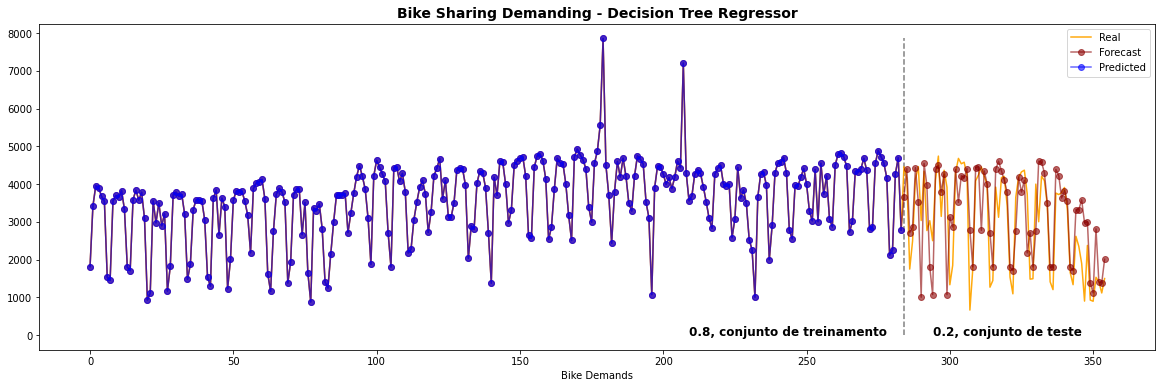

In [107]:
plot_forecast(y, y_pred, X_train, title='Bike Sharing Demanding - Decision Tree Regressor')  

In [108]:
dict_metrics = {}

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1),print_flag=False)
dict_metrics['DecisionTreeRegressor'] = cur_metrics

print('MAE para DecisionTreeRegressor:', dict_metrics['DecisionTreeRegressor']['MAE'])

MAE para DecisionTreeRegressor: 687.9577464788732


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


### XGBoost Regressor

Do mesmo modo podemos aplicar o regressor `XGBoost Regressor` você pode experimentar outros modelos se quiser.

In [109]:
from xgboost.sklearn import XGBRegressor

regressor =  XGBRegressor(random_state=0)

regressor.fit(X_train,y_train.values.reshape(-1))

y_pred = regressor.predict(X)

[14:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


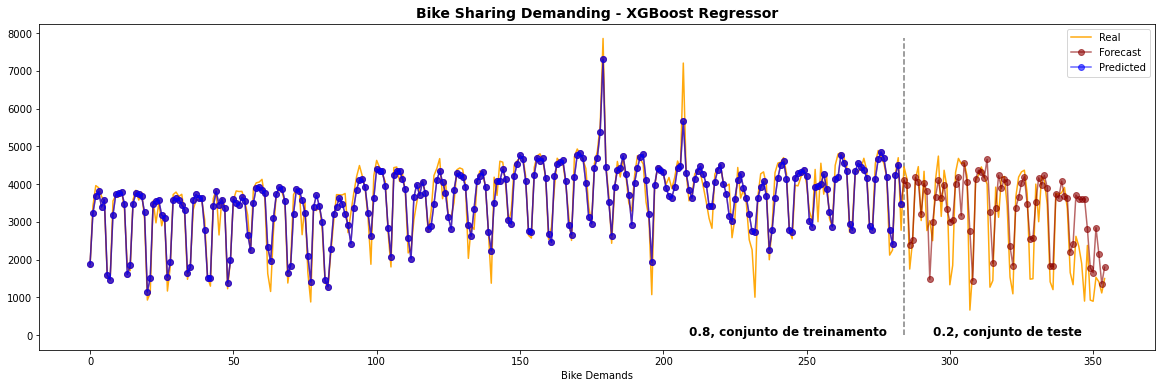

MAE para GradientBoostingRegressor: 622.8062314315581


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [110]:
plot_forecast(y, y_pred, X_train, title='Bike Sharing Demanding - XGBoost Regressor') 

cur_metrics = forecast_accuracy(y_pred[len(y_train):], y[len(y_train):].values.reshape(-1),print_flag=False)
dict_metrics['GradientBoostingRegressor'] = cur_metrics

print('MAE para GradientBoostingRegressor:', dict_metrics['GradientBoostingRegressor']['MAE'])


Selecionando a métrica MAE (erro quadrático médio) dos dois modelos você observa um menor erro do modelo `GradientBoostingRegressor`. É fácil ver que você pode aqui também aplicar o mesmo esquema de seleção de modelos e de hiperparâmetros com o  `GridSearchCV` que empregamos antes para regressores para escolher entre inúmeros outros modelos e hiperparâmetros um melhor modelo, tendo em mãos uma solução bastante poderosa para a previsão de Séries Temporais com modelos de Aprendizado de Máquina. Essa tarefa, entretanto, vamos deixar para você! ;-) 

# Síntese

Nesta aula você explorou modelos completos de aprendizado supervisionado, tanto para Classificação  como para Regressão fazendo a Seleção de **melhores hiperparâmetros** dos modelos e  também a **seleção de diferentes modelos** que competem. Você também teve contato vários outros modelos importantes, como **modelos neurais** e **regressores não lineares**, e você pôde ver como eles podem ser **facilmente aplicados** com o que você já aprendeu aqui, mesmo sem ter aprendido completamente seus princípios (o que você verá em outras disciplinas mais adiante!).

Você também pôde trabalhar aqui com  dois conjuntos de dados um pouco diferentes dos dados simplesmente tabulares que empregamos antes. Trabalhar **Dados de Imagens** e **Séries Temporais**, mesmo com modelos simples de aprendizado, permite você compreender melhor a capacidade e limitações desses modelos, abrindo o espaço para você entender modelos mais complexos que você verá na sequencia do seu curso em outras disciplinas. 




# Para Saber Mais

* Interessado em saber mais sobre o uso de Aprendizado de Máquina para previsão de Séries Temporais? Acesse **Kaggle Time Series** Um curso online com uma aborgem de Aprendizado de Máquina e Engenharia de Features aplicado à Séries Uni e Multivariadas  https://www.kaggle.com/learn/time-series.

* **Modelos Estatísticos para Séries Temporais**. Previsões de Séries Temporais são feitas à muito tempo, mesmo antes de surgirem modelos de aprendizado de máquina. Aqui você pode explorar os modelos estatísticos tradicionais de Séries Temporais aplicados com Python. **Time Series Forecasting in Python** | Book Online & Videos https://livebook.manning.com/book/time-series-forecasting-in-python-book/welcome/v-8/ https://www.youtube.com/channel/UC-0lpiwlftqwC7znCcF83qg/featured

* Acesse o Site de **THE MNIST DATABASE
of handwritten digits** http://yann.lecun.com/exdb/mnist/ para ver alguns do benchmarks de classificação da base MNIST. **Yann LeCun** é um dos mais influentes cientistas de IA e Aprendizado de Máquina, um dos criadores dos modelos de Deep Learning e Cientista Chefe de IA da Meta (FaceBook).

* Explore diferentes modelos de classificação com o `scikit-learn`. Você pode começar por aqui:

> * **Choosing the right estimator** https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html, ou  

> * **Classifier comparison** https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

* Que tal criar seus *próprios projetos* empregando os mesmos dados que empregamos aqui mas com outros modelos, ou empregue outros dados de interesse. Procure explorar modelos mais elaborados como SVC (Support Vector Machines) e AdaBoostClassifier, e empregar dados com mais classes de saída e maior volume de casos. Você também pode empregar modelos Árvore ou mesmo de K-vizinhos mais próximos para regressões não lineares. Os modelos código e o que você aprendeu até aqui são bastante suficientes para você avançar bastante rapidamente nesses projetos.





# Referências

* Larose, Chantal D.; Larose, Daniel T. **Data Science Using Python and R** Hoboken: Wiley, c2019. E-book (259 p.) (Wiley Series on Methods and Applications in Data Mining Ser.). ISBN 9781119526834 (electronic bk.). Disponível em: https://www3.mackenzie.br/biblioteca_virtual/index.php?tipoBiblio=ebookcentral&flashObg=n

* Kotu, Vijay; Deshpande, Balachandre **Data Science: concepts and practice**. 2nd ed. Cambridge, [England]: Morgan Kaufmann, c2019. E-book (570 p.) ISBN 9780128147627 (electronic bk.). Disponível em: http://pergamum.mackenzie.br:8080/pergamumweb/vinculos/00003c/00003cef.jpg.

* Jake VanderPlas. **Python Data Science Handbook**  O'Reilly Media, Inc. (2016). ISBN: 9781491912058. Disponível em: https://jakevdp.github.io/PythonDataScienceHandbook/. Acesso:15 de Maio de 2022.

* Oliveira, Rogério de; Albarracin, Orlando, Y.E.; Silva, Gustavo Rocha. **Séries Temporais para Engenharia e Outras Áreas**. (to be appear, 2023). Editora Mackenzie, Coleção Conexão Inicial.

* ___.  **Tuning the hyper-parameters of an estimator**, Disponível em: https://scikit-learn.org/stable/modules/grid_search.html#grid-search Acesso em: 15 de Maio de 2022.

* ___. **Parameter estimation using grid search with cross-validation**, Disponível em: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py Acesso em: 15 de Maio de 2022.

* ___. **Kaggle Time Series | Course Online**, Disponível em: https://www.kaggle.com/learn/time-series. Acesso em: 15 de Maio de 2022.
